

Dataset:  

standardizedindictors.xlsx  (standardized indicator values for the years 2010-2014 and 2013-2017)

In [1]:
#import libararies
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import math
from numpy.linalg import eig
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

<h3> Intro </h3>

Principal Component Analysis (PCA) is based on the idea that  dimensionality of data can be reduced by projecting onto a lower dimensional subspace which captures as much of the variance as possible.  To illustrate this idea, we will make a plot of standardized COVID-19 test rates vs. death rates by Chicago zip-code. We will  then observe for a subset of this data how projecting the data onto the y-axis (death rate) will be more informative than projecting the data onto the x-axis (tst rate) since the test rates are roughly equal.

1) Let's read in up to 100,000 rows of COVID data for Chicago from the Chicago Data Portal. We create a list called chipzip of the Chicago zip codes.

In [2]:
rawCOVID = pd.read_json('https://data.cityofchicago.org/resource/yhhz-zm2v.json?$limit=100000') #Import data directly from data portal
rawCOVID.head(2)

,:@computed_region_43wa_7qmu,:@computed_region_6mkv_f3dw,:@computed_region_bdys_3d7i,:@computed_region_rpca_8um6,:@computed_region_vrxf_vc4k,case_rate_cumulative,case_rate_weekly,cases_cumulative,cases_weekly,death_rate_cumulative,...,row_id,test_rate_cumulative,test_rate_weekly,tests_cumulative,tests_weekly,week_end,week_number,week_start,zip_code,zip_code_location
0,36.0,14311.0,367.0,34.0,38.0,NaN,NaN,NaN,NaN,0.0,...,60603-2020-10,0.0,0.0,0,0.0,2020-03-07T00:00:00.000,10,2020-03-01T00:00:00.000,60603,"{'type': 'Point', 'coordinates': [-87.625473, ..."
1,36.0,14311.0,367.0,34.0,38.0,NaN,NaN,NaN,NaN,0.0,...,60603-2020-11,0.0,0.0,0,0.0,2020-03-14T00:00:00.000,11,2020-03-08T00:00:00.000,60603,"{'type': 'Point', 'coordinates': [-87.625473, ..."


2) We'll list the 26 column names

In [3]:
list(rawCOVID.columns)

[':@computed_region_43wa_7qmu',
 ':@computed_region_6mkv_f3dw',
 ':@computed_region_bdys_3d7i',
 ':@computed_region_rpca_8um6',
 ':@computed_region_vrxf_vc4k',
 'case_rate_cumulative',
 'case_rate_weekly',
 'cases_cumulative',
 'cases_weekly',
 'death_rate_cumulative',
 'death_rate_weekly',
 'deaths_cumulative',
 'deaths_weekly',
 'percent_tested_positive_cumulative',
 'percent_tested_positive_weekly',
 'population',
 'row_id',
 'test_rate_cumulative',
 'test_rate_weekly',
 'tests_cumulative',
 'tests_weekly',
 'week_end',
 'week_number',
 'week_start',
 'zip_code',
 'zip_code_location']

3) Let's make a list of the zipcodes.

In [4]:
zips=rawCOVID["zip_code"].value_counts()
ziplist=zips.sort_index()
print("Number of zipcodes=",len(ziplist))
ziplist.index

Number of zipcodes= 60


Index(['60601', '60602', '60603', '60604', '60605', '60606', '60607', '60608',
       '60609', '60610', '60611', '60612', '60613', '60614', '60615', '60616',
       '60617', '60618', '60619', '60620', '60621', '60622', '60623', '60624',
       '60625', '60626', '60628', '60629', '60630', '60631', '60632', '60633',
       '60634', '60636', '60637', '60638', '60639', '60640', '60641', '60642',
       '60643', '60644', '60645', '60646', '60647', '60649', '60651', '60652',
       '60653', '60654', '60655', '60656', '60657', '60659', '60660', '60661',
       '60666', '60707', '60827', 'Unknown'],
      dtype='object')

4) Let's streamline the data to just a few columns, drop rows with missing data,  simplify the column names, and then display the first 2 rows.

In [5]:
COVID=rawCOVID[['deaths_cumulative', "population",  'tests_cumulative','zip_code']]
COVID.columns=["deaths","population","tests","zip"] #simplify the column names
COVID=COVID.dropna()
print("Number of row and columns=",COVID.shape)
COVID.head(2)

Number of row and columns= (8640, 4)


,deaths,population,tests,zip
0,0,1174,0,60603
1,0,1174,0,60603


In [6]:
ziplist.index[0]

'60601'

5) Let's create a dataframe called data which contains for each zip code: (i) the population; (ii) the test rate (number of tests per person); and (iii) the death rate (number of deaths per 100,000 people).

In [7]:
data=pd.DataFrame()
for i in np.arange(0,59,1):
    z=ziplist.index[i]
    temp = COVID[COVID["zip"]==str(z)]
    p=temp["population"].max()
    t=temp["tests"].max()
    d=temp["deaths"].max()
    data.loc[i,"zip"]=str(z)
    data.loc[i,"test rate"]=t/p  #test rate = number of tests per person
    data.loc[i,"death rate"]=d/p #death rate = number of deaths per person
data=data[data["zip"]!='60666']
data=data.reset_index(drop=True) #renumbers the index
data.head(2)

C:\Users\pisihara\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in longlong_scalars
  if __name__ == '__main__':
C:\Users\pisihara\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  # Remove the CWD from sys.path while we load stuff.


,zip,test rate,death rate
0,60601,6.913867,0.000886
1,60602,9.665595,0.002412


6) Let's make a graph which shows the test rate and death rate by zip code. 

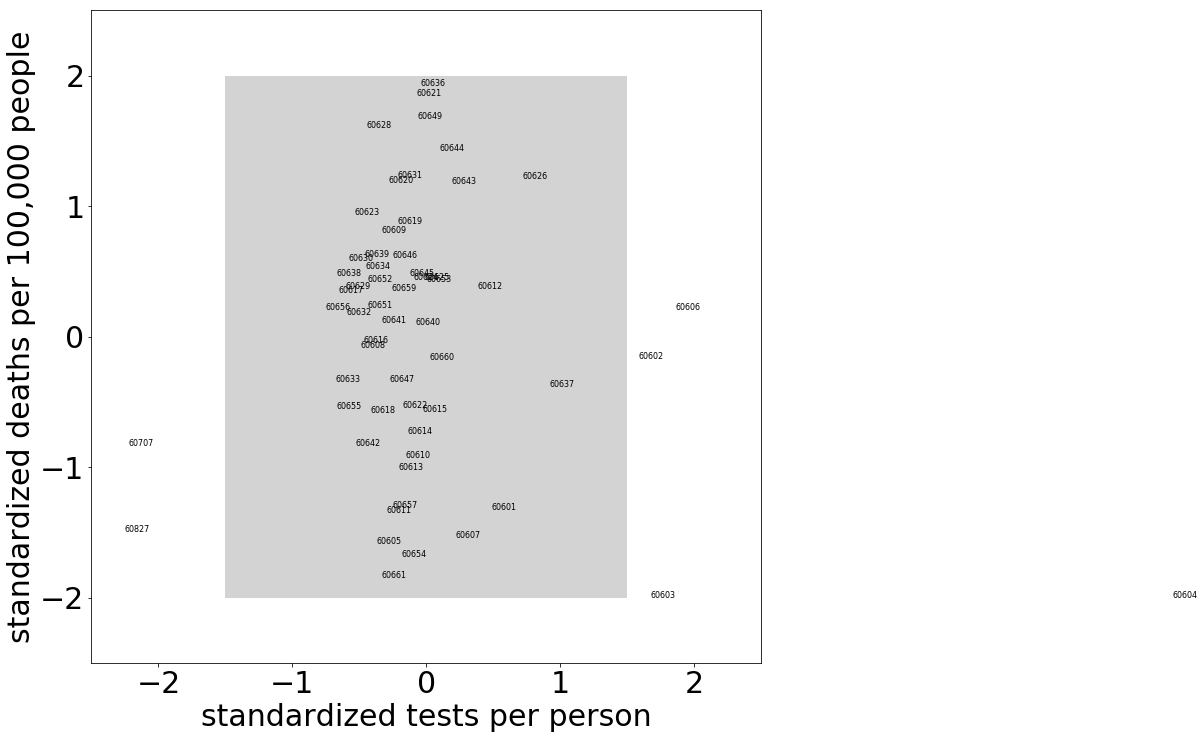

In [8]:
fig=plt.figure(figsize=(12,12))
plt.ylim(-2.5,2.5)
plt.xlim(-2.5,2.5)
xm=np.mean(data["test rate"])
xs=np.std(data["test rate"])
ym=np.mean(data["death rate"])
ys=np.std(data["death rate"])
for i in np.arange(0,58):
        z=data.loc[i,"zip"]
        plt.text((data.loc[i,"test rate"]-xm)/xs,(data.loc[i,"death rate"]-ym)/ys,z,size=8,color='black',ha='center',va='center')
        data.loc[i,"std test rate"]=(data.loc[i,"test rate"]-xm)/xs
        data.loc[i,"std death rate"]=(data.loc[i,"death rate"]-ym)/ys
plt.xlabel("standardized tests per person",size=30)
plt.ylabel("standardized deaths per 100,000 people",size=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.gca().add_patch(Rectangle((-1.5, -2), 3, 4,fc ='lightgray'))
plt.savefig("chistandardcovid.png")

In [9]:
data.head()

,zip,test rate,death rate,std test rate,std death rate
0,60601,6.913867,0.000886,0.580469,-1.311419
1,60602,9.665595,0.002412,1.676577,-0.149852
2,60603,9.901193,0.000000,1.770423,-1.985848
3,60604,19.681586,0.000000,5.666289,-1.985848
4,60605,4.760166,0.000545,-0.277424,-1.570866


In [10]:
print("variance test rate",np.std(data["std test rate"])**2)
print("variance death rate",np.std(data["std death rate"])**2)

variance test rate 1.0
variance death rate 0.9999999999999991


In [11]:
data1=data[data["zip"]!='60707']
data1=data1[data1["zip"]!='60827']
data1=data1[data1["zip"]!='60606']
data1=data1[data1["zip"]!='60602']
data1=data1[data1["zip"]!='60603']
data1=data1[data1["zip"]!='60604']
print("variance test rate",np.std(data1["std test rate"])**2)
print("variance death rate",np.std(data1["std death rate"])**2)

variance test rate 0.11583206544615858
variance death rate 0.8931531613437289


<h2> 1. Example: Hardship Index</h2>
We will now show that PCA projects standardized data onto a 1-dimensional subspace (i.e. straight line through the origin) which maximizes the projected variance.We will consider standardzed data for 6 Standardized Hardship Indicators for 77 Chicago Community Areas.

The indicators are abbreviated as follows:

<ul>
    <li> UNEMP = % of community age 16 and older who are unemployed. </li>
     <li> NOHS = % of community age 25 and older without a high school diploma. </li>
         <li> DEP = % of community who are dependent (under age 18 or over age 64). </li>
             <li> HOUS= % of community with overcrowded housing (more than 1 occupant per room).</li>
                 <li> POV = % below federal poverty line
    <li> INC = per capita income.</li>
             
Source: https://greatcities.uic.edu/wp-content/uploads/2016/07/GCI-Hardship-Index-Fact-SheetV2.pdf (2010-2014) https://greatcities.uic.edu/wp-content/uploads/2019/12/Hardship-Index-Fact-Sheet-2017-ACS-Final-1.pdf (2013-2017).

1) import the usual libraries

In [12]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt # plotting library

2) Import library for KMeans clustering

In [13]:
import sklearn
from sklearn.cluster import KMeans 

3) Read hardship index data.

In [14]:
hom_df = pd.read_excel('standardizedindicators.xlsx')
hom_df.head(2)

,Community,index,HI14,UNEMP14,NOHS14,DEP14,HOUS14,POV14,INC14,HI17,UNEMP17,NOHS17,DEP17,HOUS17,POV17,INC17,HOM14,HOM17,LAT,LON
0,Albany Park,13,47.0,-0.705481,0.667993,-0.470891,1.42992,-0.353466,-0.165118,45.7,-0.706842,0.506067,-0.530539,1.562581,-0.418499,-0.183089,2,1,41.96823,-87.72421
1,Archer Heights,56,54.4,-0.193683,1.136956,0.471085,1.51857,-0.672245,-0.605100,56.1,-0.442634,1.090575,0.742190,1.945762,-0.473646,-0.607925,0,3,41.81093,-87.72677


4) Create dataframe with the 2017 indicator values.

In [15]:
HI17=hom_df[["UNEMP17","NOHS17","DEP17","HOUS17","POV17","INC17"]]
HI17.head(2)

,UNEMP17,NOHS17,DEP17,HOUS17,POV17,INC17
0,-0.706842,0.506067,-0.530539,1.562581,-0.418499,-0.183089
1,-0.442634,1.090575,0.742190,1.945762,-0.473646,-0.607925


5) Create a dataframe with just the unemployment and income data.

In [16]:
EMPINC=HI17[["UNEMP17","INC17"]]
EMPINC.head(2)

,UNEMP17,INC17
0,-0.706842,-0.183089
1,-0.442634,-0.607925


5) Check that the 6 dimensional data points have been projected onto a 1 dimensional line.

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
projected = pca.fit_transform(EMPINC)
print(HI17.shape)
print(projected.shape)

(77, 6)
(77, 1)


6) Get the values on the projected line.

In [18]:
print(pca.components_) #unit vector specifying direction of the principal component line
projected[0]

[[-0.70710678  0.70710678]]


array([0.3703489])

In [19]:
print(pca.explained_variance_)

[1.66614794]


In [20]:
projected.var()

1.6445096544427147

7) Plot the points (UNEMP17,INC17) and the projection of these points onto the line y= -x.

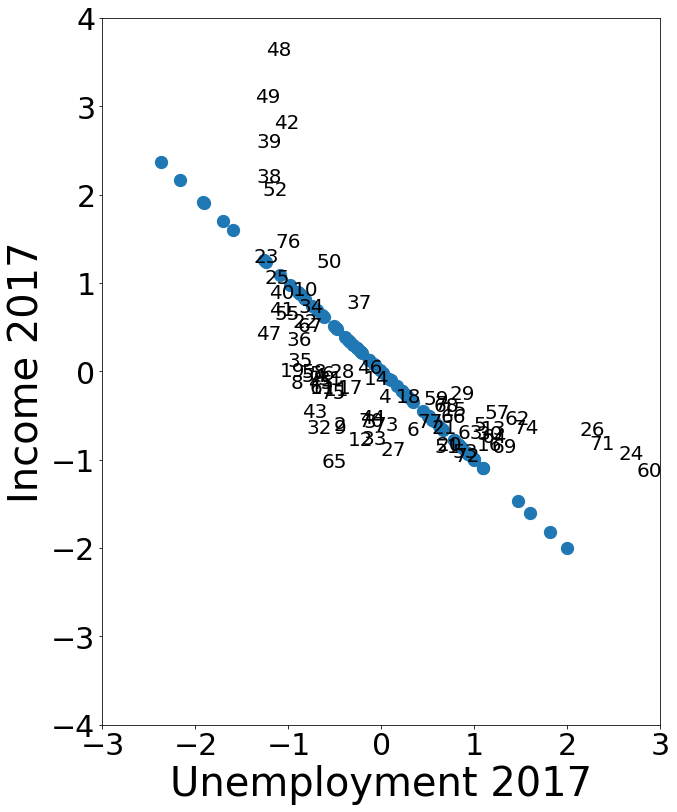

In [21]:
fig=plt.figure(figsize=(10,13))
plt.scatter(-projected[:, 0]/np.sqrt(2), projected[:, 0]/np.sqrt(2), s=150)
for i in EMPINC.index:
    plt.text(EMPINC.loc[i,"UNEMP17"],EMPINC.loc[i,"INC17"],str(i+1),size=20,va='center',ha='center')
plt.xlim(-3, 3) 
plt.ylim(-4, 4)
plt.xlabel('Unemployment 2017',size=40)
plt.ylabel('Income 2017',size=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.savefig("empinc.png")

In [22]:
import statistics as stat
print("Variance of Unemployment", stat.variance(EMPINC["UNEMP17"]))
print("Variance of Income", stat.variance(EMPINC["INC17"]))
print("Variance of Projection",stat.variance(projected[:, 0]))

Variance of Unemployment 1.0131578947368423
Variance of Income 1.013157894736842
Variance of Projection 1.6661479393695926


Practice:

Repeat the above analysis using "NOHS17" and "POV17".

<h2>2. EXERCISE: PCA LETTER RECOGNITION</h2>
In this exercise, we are going to use Principal Component Analysis (PCA) to reduce 64x64 bit images of the letters `a' and `b' represented as $64^2$ dimensional vectors onto a 2 dimensional subspace.   

All the 8 letter images (four a's and four b's) should be in a sub-folder called `letters`, located within the same folder that this JNB is located.

Datafiles: a1.png, a2.png, a3.png, a4.png, b1.png, b2.png, b3.png, b4.png

1) Run the following cell with `!pip install opencv-python`. (Click the playbutton in your environment when the cell is highlighted).

In [23]:
!pip install opencv-python

2) Import libraries.

In [24]:
import numpy as np
import matplotlib
import pandas as pd
import cv2, os
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib as mpl
import seaborn as sns; sns.set()
import math
import folium
from folium.features import DivIcon
matplotlib.use('Agg')
matplotlib.style.use('fivethirtyeight')
from sklearn.datasets import fetch_lfw_people, fetch_olivetti_faces
%matplotlib inline
from ipywidgets import interact

C:\Users\pisihara\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\pisihara\AppData\Local\Continuum\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\pisihara\AppData\Local\Continuum\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\pisihara\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\pisihara\AppData\Local\Continuum\anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "

3) The following function converts images in a folder to a matrix of column vectors containing pixel values for each image.

In [25]:
def imagetovector(npix,directory,nimages):
    n=npix  #use nxn pixel image
    # You'll want to store all your images in a folder within the same directory as this notebook. 
    # Enter the name of that directory below.
    directory = directory # example: "images"

    # Dictionaries to store the image data and the dataframes we'll make from them.
    # The dataframes are used to translate data to and from excel.
    imgs = {}
    dfs = {}

    # Each image will be resized to ensure that their proportions are consistent with each other.
    # It's best to start with images that are already similarly sized so that images don't get
    # too distorted in the resize process. 
    # Adjust the size to your preference: (width, height)
    dsize = (n, n)

    # This will iterate over every image in the directory given, read it into data, and create a 
    # dataframe for it. Both the image data and its corresponding dataframe are stored.
    # Note that when being read into data, we interpret the image as grayscale. 
    pos = 0
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            imgs[pos] = cv2.imread(f, 0) # image data
            imgs[pos] = cv2.resize(imgs[pos], dsize)
            dfs[pos] = pd.DataFrame(imgs[pos]) # dataframe
            pos += 1

    # Exports the image dataframes to an excel file, with each excel sheet representing one image.
    # If there's already an excel file by the same name, it will overwrite it. Note that if the
    # excel file it's attempting to overwrite is already open, the write will be blocked.
    with pd.ExcelWriter('image_data.xlsx') as writer: 
        for i in np.arange(0, len(dfs)):
            dfs[i].to_excel(writer, sheet_name=str(i))
    def matrixtovector(matrix,n,s):
        t=0
        vec=pd.DataFrame()
        for i in np.arange(0,n,1):
            for j in np.arange(0,n,1):
                vec.loc[t,str(s)]=matrix.loc[i,j]
                t=t+1
        return vec

    numimages=nimages
    data=pd.DataFrame()
    for t in np.arange(0,numimages,1):
        data.loc[:,str(t)]=matrixtovector(dfs[t],n,t)            
    return data,imgs

4) Run the next code cells to test if you were able to use the correct path name. If not, go back and check if the images are in the file you copied the path name of, or check if you copied the correct path name. 
- The data set will be the 8 images in the folder "letters" with a $64 \times 64$ resolution.

In [26]:
[traindata,imgs]=imagetovector(64,"letters",8)
traindata.head(4)

,0,1,2,3,4,5,6,7
0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
1,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
2,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
3,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0


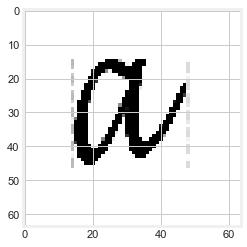

In [27]:
#display the first  image
plt.imshow(imgs[0], cmap="gray") 

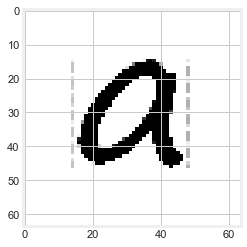

In [28]:
#display the second  image
plt.imshow(imgs[1], cmap="gray") 

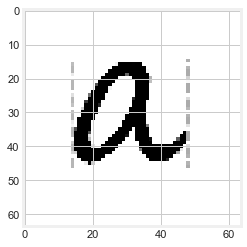

In [29]:
#display the third image
plt.imshow(imgs[2], cmap="gray") 

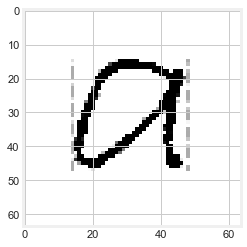

In [30]:
#display the fourth training image
plt.imshow(imgs[3], cmap="gray") 

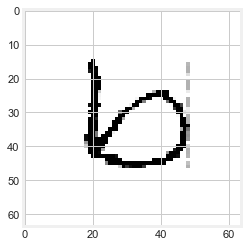

In [31]:
#display the fifth training image
plt.imshow(imgs[4], cmap="gray")

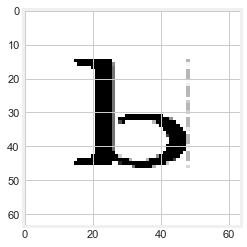

In [32]:
#display the sixth image
plt.imshow(imgs[5], cmap="gray")

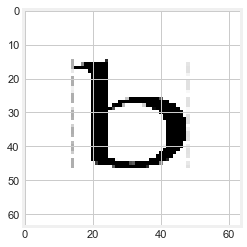

In [33]:
#display the seventh image
plt.imshow(imgs[6], cmap="gray")

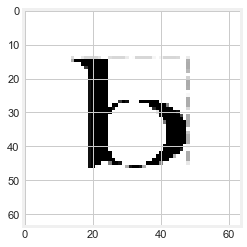

In [34]:
#display the eight image
plt.imshow(imgs[7], cmap="gray")

In [35]:
#store the data in an Excel file
letter=traindata
letter.to_excel("ab.xlsx")

5) We will now use PCA to project the data onto the first 2 principal component vectors.

In [36]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(np.transpose(letter))
letter_pca = pca.transform(np.transpose(letter))
print("original shape:   ", np.transpose(letter).shape)
print("transformed shape:", letter_pca.shape)

original shape:    (8, 4096)
transformed shape: (8, 2)


In [37]:
print(pca.components_)

[[ 8.89354071e-17  2.03495534e-17  2.08839710e-17 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.29552296e-16  2.30524383e-16 -1.39857897e-16 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


6) Let's check how well we can recognize the  2-dimensional versions of each image.

In [38]:
filtered = pca.inverse_transform(letter_pca)

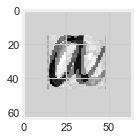

In [39]:
fig=plt.figure(figsize=(2,2))
plt.gca().imshow(filtered[0].reshape(64, 64),
                  cmap="gray")

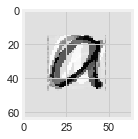

In [40]:
fig=plt.figure(figsize=(2,2))
plt.gca().imshow(filtered[1].reshape(64, 64),
                                 cmap="gray")

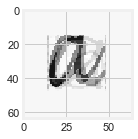

In [41]:
fig=plt.figure(figsize=(2,2))
plt.gca().imshow(filtered[2].reshape(64, 64),
                                 cmap="gray")

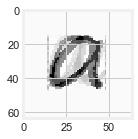

In [42]:
fig=plt.figure(figsize=(2,2))
plt.gca().imshow(filtered[3].reshape(64, 64),
                                 cmap="gray")

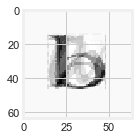

In [43]:
fig=plt.figure(figsize=(2,2))
plt.gca().imshow(filtered[4].reshape(64, 64),
                                 cmap="gray")

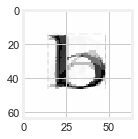

In [44]:
fig=plt.figure(figsize=(2,2))
plt.gca().imshow(filtered[5].reshape(64, 64),
                                 cmap="gray")

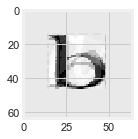

In [45]:
fig=plt.figure(figsize=(2,2))
plt.gca().imshow(filtered[6].reshape(64, 64),
                                 cmap="gray")

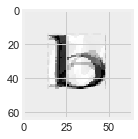

In [46]:
fig=plt.figure(figsize=(2,2))
plt.gca().imshow(filtered[7].reshape(64, 64),
                                 cmap="gray")

7) Here are the images corresponding to the 2 basis vectors for the 2D subspace determined by the first two principal components. 

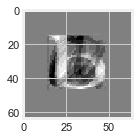

In [47]:
#Image corresponding to the 1st basis vector.
fig=plt.figure(figsize=(2,2))
plt.gca().imshow(pca.components_[0].reshape(64, 64),
                                 cmap="gray")

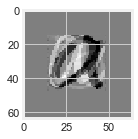

In [48]:
#image corresponding to the 2nd basis vector.
fig=plt.figure(figsize=(2,2))
plt.gca().imshow(pca.components_[1].reshape(64, 64),
                                 cmap="gray")

8) The coordinates of the first letter `a` with respect to the above PCA basis vectors are obtained as follows:

In [49]:
letter_pca[0]

array([ 2560.35577449, -2207.80661615])

<h4> Questions </h4>

a) Explain why the original images displayed in step 4) are $64^2$ dimensional, and the PCA images displayed in step 6) are only 2 dimensional?

b) What would happen if instead of using the PCA basis, we used two standard basis vectors for the projections  (eg. $e_1=(1,0,0,0,...,0)$ and $e_2=(0,1,0,0,...,0)$?